In [0]:
# перезагрузить ноутбук
!kill -9 -1

# Разделение аудиопотока (фразы) на отдельные слова 

Копирование файлов с Git на локальный диск виртуальной машины - вставка ссылки с гитхаба: 

In [0]:
!git clone https://github.com/smartsinovich/Simple-Audio-Recognition.git

fatal: destination path 'Simple-Audio-Recognition' already exists and is not an empty directory.


In [0]:
!pip install soundfile

In [0]:
!pip install pydub



---



In [0]:
import numpy as np
import random
import itertools
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline
import soundfile as sf
from scipy.io import wavfile
import scipy.io.wavfile

import numpy as np
import random
import itertools
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

import soundfile as sf
from scipy.io import wavfile
import scipy.io.wavfile
import matplotlib.pyplot as plt


Загружаем файл аудиопотока для дальнейшей обработки из директория Seg_audio_streams

Это файл с сильно уменьшенным количеством данных. Он нужен только для определения точек разреза.

/content/Simple-Audio-Recognition/Seg_audio_streams/seg_no_bed_bird.wav
samples = 120   sample rate = 40   seconds = 3.0
40 [     0      0      0      0      0      0      0    117    861   -268
    509   3850   1405   1119  -2602    213   1192  -3022   -337  -1292
  -5351   1128    123   1034   -167   -309     22      7      0      3
      0     -1      0    -30   -128     63     -5     92      8    -35
     11     57    -62     -3     47     23    101     40  -1149  -5153
   7368  -9440 -13747  -4643   1609   4278    529    843   2560  -1500
   2463    598    264    122    146   -102      0      0      0      0
      0      0      0    -46     28     65    236     58    -26    133
   -123   1131   3820    237  -3607   -491   3222   3871  -8924  -7897
   5990  -1497    904   2201    942     98   -327    200   -162    -67
     -9      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0]


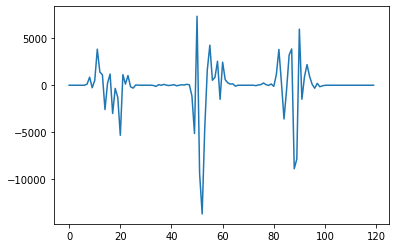

In [0]:
#segmented_file = '/content/Simple-Audio-Recognition/Seg_audio_streams/seg_up_dog_marvin.wav'
segmented_file = '/content/Simple-Audio-Recognition/Seg_audio_streams/seg_no_bed_bird.wav'


print(segmented_file)
f = sf.SoundFile(segmented_file)
print('samples = {}'.format(len(f)), '  sample rate = {}'.format(f.samplerate), '  seconds = {}'.format(len(f) / f.samplerate))
rate, data = scipy.io.wavfile.read(segmented_file)
print(rate, data)
plt.plot(data)
plt.show()

Выполним ряд преобразований.

Цель: 

1.   Избавиться от шума - выделить моменты тишины
2.   Определить середины периодов тишины для последующего разрезания аудиопотока



In [0]:
a = np.array(data)
a

array([     0,      0,      0,      0,      0,      0,      0,    117,
          861,   -268,    509,   3850,   1405,   1119,  -2602,    213,
         1192,  -3022,   -337,  -1292,  -5351,   1128,    123,   1034,
         -167,   -309,     22,      7,      0,      3,      0,     -1,
            0,    -30,   -128,     63,     -5,     92,      8,    -35,
           11,     57,    -62,     -3,     47,     23,    101,     40,
        -1149,  -5153,   7368,  -9440, -13747,  -4643,   1609,   4278,
          529,    843,   2560,  -1500,   2463,    598,    264,    122,
          146,   -102,      0,      0,      0,      0,      0,      0,
            0,    -46,     28,     65,    236,     58,    -26,    133,
         -123,   1131,   3820,    237,  -3607,   -491,   3222,   3871,
        -8924,  -7897,   5990,  -1497,    904,   2201,    942,     98,
         -327,    200,   -162,    -67,     -9,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

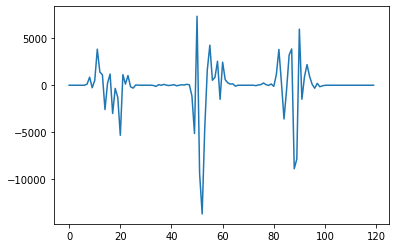

In [0]:
plt.plot(a)
plt.show()

In [0]:
abs_a = np.abs(a)
abs_a

array([    0,     0,     0,     0,     0,     0,     0,   117,   861,
         268,   509,  3850,  1405,  1119,  2602,   213,  1192,  3022,
         337,  1292,  5351,  1128,   123,  1034,   167,   309,    22,
           7,     0,     3,     0,     1,     0,    30,   128,    63,
           5,    92,     8,    35,    11,    57,    62,     3,    47,
          23,   101,    40,  1149,  5153,  7368,  9440, 13747,  4643,
        1609,  4278,   529,   843,  2560,  1500,  2463,   598,   264,
         122,   146,   102,     0,     0,     0,     0,     0,     0,
           0,    46,    28,    65,   236,    58,    26,   133,   123,
        1131,  3820,   237,  3607,   491,  3222,  3871,  8924,  7897,
        5990,  1497,   904,  2201,   942,    98,   327,   200,   162,
          67,     9,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int16)

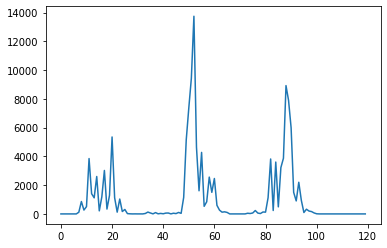

In [0]:
plt.plot(abs_a)
plt.show()

In [0]:
porog = 50 # порог чтобы срезать шум
b = abs_a.clip(porog, abs_a.max())
b

array([   50,    50,    50,    50,    50,    50,    50,   117,   861,
         268,   509,  3850,  1405,  1119,  2602,   213,  1192,  3022,
         337,  1292,  5351,  1128,   123,  1034,   167,   309,    50,
          50,    50,    50,    50,    50,    50,    50,   128,    63,
          50,    92,    50,    50,    50,    57,    62,    50,    50,
          50,   101,    50,  1149,  5153,  7368,  9440, 13747,  4643,
        1609,  4278,   529,   843,  2560,  1500,  2463,   598,   264,
         122,   146,   102,    50,    50,    50,    50,    50,    50,
          50,    50,    50,    65,   236,    58,    50,   133,   123,
        1131,  3820,   237,  3607,   491,  3222,  3871,  8924,  7897,
        5990,  1497,   904,  2201,   942,    98,   327,   200,   162,
          67,    50,    50,    50,    50,    50,    50,    50,    50,
          50,    50,    50,    50,    50,    50,    50,    50,    50,
          50,    50,    50], dtype=int16)

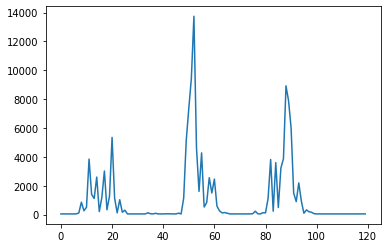

In [0]:
plt.plot(b)
plt.show()

In [0]:
# создадим такой же массив, заполним его одинаковыми элементами
c = b.copy()
c

array([   50,    50,    50,    50,    50,    50,    50,   117,   861,
         268,   509,  3850,  1405,  1119,  2602,   213,  1192,  3022,
         337,  1292,  5351,  1128,   123,  1034,   167,   309,    50,
          50,    50,    50,    50,    50,    50,    50,   128,    63,
          50,    92,    50,    50,    50,    57,    62,    50,    50,
          50,   101,    50,  1149,  5153,  7368,  9440, 13747,  4643,
        1609,  4278,   529,   843,  2560,  1500,  2463,   598,   264,
         122,   146,   102,    50,    50,    50,    50,    50,    50,
          50,    50,    50,    65,   236,    58,    50,   133,   123,
        1131,  3820,   237,  3607,   491,  3222,  3871,  8924,  7897,
        5990,  1497,   904,  2201,   942,    98,   327,   200,   162,
          67,    50,    50,    50,    50,    50,    50,    50,    50,
          50,    50,    50,    50,    50,    50,    50,    50,    50,
          50,    50,    50], dtype=int16)

In [0]:
c.fill(porog)
c

array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50], dtype=int16)

In [0]:
d = b - c
d

array([    0,     0,     0,     0,     0,     0,     0,    67,   811,
         218,   459,  3800,  1355,  1069,  2552,   163,  1142,  2972,
         287,  1242,  5301,  1078,    73,   984,   117,   259,     0,
           0,     0,     0,     0,     0,     0,     0,    78,    13,
           0,    42,     0,     0,     0,     7,    12,     0,     0,
           0,    51,     0,  1099,  5103,  7318,  9390, 13697,  4593,
        1559,  4228,   479,   793,  2510,  1450,  2413,   548,   214,
          72,    96,    52,     0,     0,     0,     0,     0,     0,
           0,     0,     0,    15,   186,     8,     0,    83,    73,
        1081,  3770,   187,  3557,   441,  3172,  3821,  8874,  7847,
        5940,  1447,   854,  2151,   892,    48,   277,   150,   112,
          17,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int16)

In [0]:
e = d.clip(0, 1)
e

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int16)

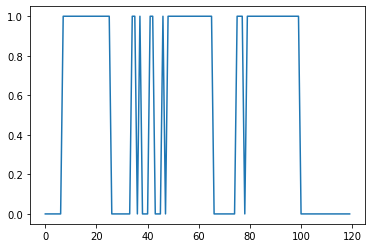

In [0]:
plt.plot(e)
plt.show()



---



# Определяем координаты центров тишины. 
Эти координаты будут использованы для разрезания аудиопотока на части - фразу делим на слова



---



---



---



In [0]:
a = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], int)



In [0]:
a = e.copy()
a

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int16)

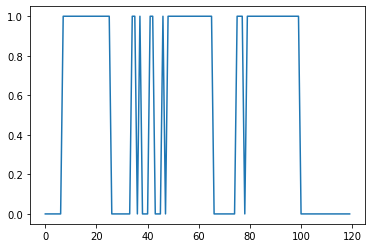

In [0]:
plt.plot(a)
plt.show()

Решение берем отсюда: https://younglinux.info/python/task/id-range

In [0]:

#def my_function(a): # задаем массив
   
count = 0
max_count = 0
index = 0
i = 0 
while i < len(a):
	if a[i] == 1:
		count += 1
	else:
		if count > max_count:
			max_count = count
			index = i-1 # последовательность закончилась на предыдущем элементе
		count = 0
	i += 1

  
 
print("Количество элементов: ", max_count)
print("id первого элемента: ", index-max_count+1)
print("id последнего элемента: ", index)
print("середина", int(round(index - max_count/2)))
sound_center = round(index - max_count/2)
sound_center_i = sound_center
print(sound_center_i)
sound_center_list = []
sound_center_list.append(sound_center_i)
print(sound_center_list)


Количество элементов:  21
id первого элемента:  79
id последнего элемента:  99
середина 88
88
[88]


In [0]:
a[index-max_count+1:index] # items start through end-1


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int16)

ОБнуляем полученное единички. ищем следущую самую длинную последовательность единичек

In [0]:

a[index-max_count+1:index] = 0 #ОБнуляем полученное единички. 

In [0]:
a1 = a


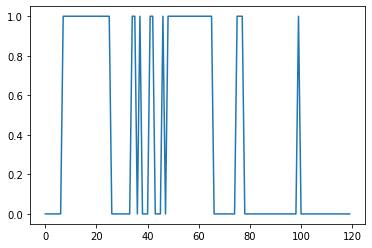

In [0]:
plt.plot(a1)
plt.show()

In [0]:
a2 = a1.copy()
a = a2

In [0]:
count = 0
max_count = 0
index = 0
i = 0 
while i < len(a):
	if a[i] == 1:
		count += 1
	else:
		if count > max_count:
			max_count = count
			index = i-1 # последовательность закончилась на предыдущем элементе
		count = 0
	i += 1
 
print("Количество элементов: ", max_count)
print("id первого элемента: ", index-max_count+1)
print("id последнего элемента: ", index)
print("середина", int(round(index - max_count/2)))
sound_center = round(index - max_count/2)
sound_center_i = sound_center
print(sound_center_i)
sound_center_list.append(sound_center_i)
print(sound_center_list)


Количество элементов:  19
id первого элемента:  7
id последнего элемента:  25
середина 16
16
[88, 16]


In [0]:
a[index-max_count+1:index] = 0 #ОБнуляем полученное единички. 

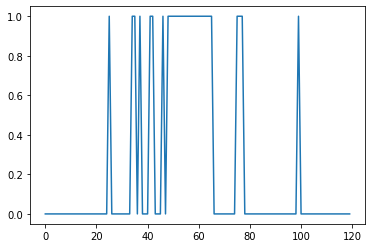

In [0]:
plt.plot(a)
plt.show()

In [0]:
# делаем копию и запускаем снова
a3 = a.copy()
a = a3

In [0]:
count = 0
max_count = 0
index = 0
i = 0 
while i < len(a):
	if a[i] == 1:
		count += 1
	else:
		if count > max_count:
			max_count = count
			index = i-1 # последовательность закончилась на предыдущем элементе
		count = 0
	i += 1
 
print("Количество элементов: ", max_count)
print("id первого элемента: ", index-max_count+1)
print("id последнего элемента: ", index)
print("середина", int(round(index - max_count/2)))
sound_center = round(index - max_count/2)
sound_center_i = sound_center
print(sound_center_i)
sound_center_list.append(sound_center_i)
print(sound_center_list)

Количество элементов:  18
id первого элемента:  48
id последнего элемента:  65
середина 56
56
[88, 16, 56]


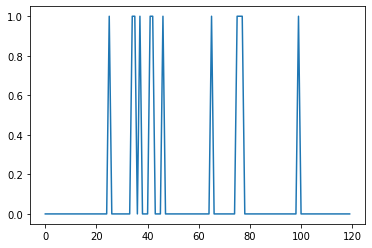

In [0]:
a[index-max_count+1:index] = 0 #ОБнуляем полученное единички.
# делаем копию и запускаем снова
a4 = a.copy()
a = a4
plt.plot(a)
plt.show()

In [0]:
count = 0
max_count = 0
index = 0
i = 0 
while i < len(a):
	if a[i] == 1:
		count += 1
	else:
		if count > max_count:
			max_count = count
			index = i-1 # последовательность закончилась на предыдущем элементе
		count = 0
	i += 1
 
print("Количество элементов: ", max_count)
print("id первого элемента: ", index-max_count+1)
print("id последнего элемента: ", index)
print("середина", int(round(index - max_count/2)))

Количество элементов:  3
id первого элемента:  75
id последнего элемента:  77
середина 76


у нас периоды звука не сильно отличаются друг от друга.

Длина звука - это в нашем случае количество элементов.
Звуки 1, 2, 3 имеют 14 индексов (количество элементов), а звук 4 - 1 элемент. 
Это означает, что более или менее длиные звуки кончились. 
Можем воспользоваться этим как сигналом для остановки поиска новых слов во фразе.
Если отношение (количество элементов для первого звука / количеств элементов следующего звука) > 2, то функцию поиска середины звука останавливаем

ИТОГО получили три индекса - центры звуков. 
C1 = середина 54.5
C2 = середина 14.0
C3 = середина 87.0

Будем искать линии разрезов
Первый разрез T0 = 0


In [0]:
C1 = 54 # взято для примера, обработка файла 'seg_no_bed_bird.wav'
C2 = 14
C3 = 87

Center_list  = sound_center_list
print(Center_list)

# ранжируем список центров звука по возростанию
Center_list.sort()
b = sorted(Center_list)
print(b)
print(range(len(b)))

T0 = 0
T1 = b[0]
T2 = b[1]
T3 = b[2]


[88, 16, 56]
[16, 56, 88]
range(0, 3)


Вычисляем точки разреза:

In [0]:
# для фразы из трех слов - это две точки, для фразы из трех слов - две.
# для файла 'seg_no_bed_bird.wav' - две точки.

S1 = round(T0 + (T1-T0)/2)
S1 = round(T1 + (T2-T1)/2)
S2 = round(T2 + (T3-T2)/2)

print(S1 )
print(S2)

Split_list = [S1, S2]
print(Split_list) 

t0 = 0
t1 = Split_list[0]
t2 = Split_list[1]
print(t0, t1, t2)
print(t1)
print

#34,70

36
72
[36, 72]
0 36 72
36


<function print>

In [0]:
sound = np.array([     0,      0,      0,      0,      0,      0,      0,    117,
          861,   -268,    509,   3850,   1405,   1119,  -2602,    213,
         1192,  -3022,   -337,  -1292,  -5351,   1128,    123,   1034,
         -167,   -309,     22,      7,      0,      3,      0,     -1,
            0,    -30,   -128,     63,     -5,     92,      8,    -35,
           11,     57,    -62,     -3,     47,     23,    101,     40,
        -1149,  -5153,   7368,  -9440, -13747,  -4643,   1609,   4278,
          529,    843,   2560,  -1500,   2463,    598,    264,    122,
          146,   -102,      0,      0,      0,      0,      0,      0,
            0,    -46,     28,     65,    236,     58,    -26,    133,
         -123,   1131,   3820,    237,  -3607,   -491,   3222,   3871,
        -8924,  -7897,   5990,  -1497,    904,   2201,    942,     98,
         -327,    200,   -162,    -67,     -9,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0], int)

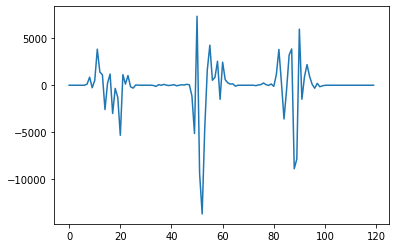

In [0]:
plt.plot(sound)
plt.show()

In [0]:
sound1 = sound[:S1]
sound1

array([    0,     0,     0,     0,     0,     0,     0,   117,   861,
        -268,   509,  3850,  1405,  1119, -2602,   213,  1192, -3022,
        -337, -1292, -5351,  1128,   123,  1034,  -167,  -309,    22,
           7,     0,     3,     0,    -1,     0,   -30,  -128,    63])

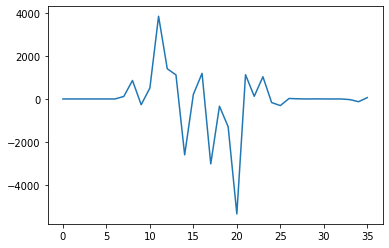

In [0]:
plt.plot(sound1)
plt.show()

In [0]:
sound2 = sound[S1:S2]

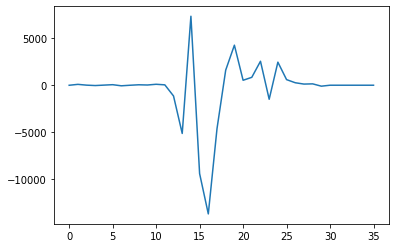

In [0]:
plt.plot(sound2)
plt.show()

In [0]:
sound3 = sound[S2:]

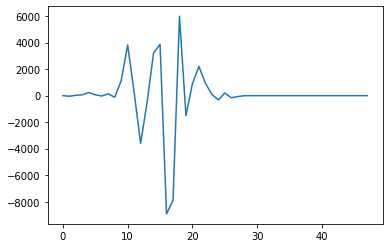

In [0]:
plt.plot(sound3)
plt.show()



---



# Продолжение на ноутбуке "Определение тишины". С его помощью будут нарезаться фразы для скармливания модели.



---



---





---



# Переносим точки разрыва на полноценный аудиопоток 
Директорий /content/Simple-Audio-Recognition/Audio_streams/

In [0]:
import os
import numpy as np
import keras
import math
from keras.models import load_model
from scipy.io import wavfile
from scipy.fftpack import dct
from scipy.io import wavfile
import scipy.io.wavfile
import matplotlib.pyplot as plt

In [0]:
#__________для ПОТОКА - файлы для директория  Seg_audio_streams
#sample_file ='no_bed_bird.wav'
sample_file ='no_bed_bird.wav'
dir_path = '/content/Simple-Audio-Recognition/Audio_streams/' #  откуда файл берется

#создаем директорий для фразы
dir_path_mod = '/content/Simple-Audio-Recognition/Words_from_streams/' + sample_file[:-4]
#dir_path_mod = '/content/Simple-Audio-Recognition/Words_from_streams/' + sample_file

if not os.path.exists('/content/Simple-Audio-Recognition/Words_from_streams/' + sample_file[:-4]): #Если пути не существует создаем его
   dir_path_mod = os.makedirs('/content/Simple-Audio-Recognition/Words_from_streams/' + sample_file[:-4])
   dir_path_mod = '/content/Simple-Audio-Recognition/Words_from_streams/' + sample_file[:-4]
print(sample_file)
print(dir_path)
print(dir_path_mod)


no_bed_bird.wav
/content/Simple-Audio-Recognition/Audio_streams/
/content/Simple-Audio-Recognition/Words_from_streams/no_bed_bird


Number of channels 1
Sample width 2
Frame rate. 16000
Number of frames 13600
parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=13600, comptype='NONE', compname='not compressed')
/content/Simple-Audio-Recognition/Words_from_streams/no_bed_bird/1_no_bed_bird.wav
16000
[   0    0    0 ... -104 -123 -122]
sound durantion =  0.85


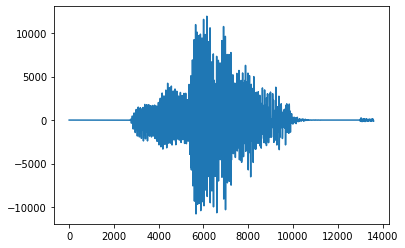

In [0]:
k0 = 0
k1 = 1000*34/40
k2 = 1000*70/40


#+++++++++++++++++++11111111111111111111111111111111111
start = 0
end = k1
x = '1_'

from pydub import silence, AudioSegment

audio = AudioSegment.from_file(dir_path + sample_file, format="wav")
print(audio)

segment = AudioSegment.from_wav(dir_path + sample_file)[start:end]  
modified_file = x +  sample_file  
segment.export(os.path.join(dir_path_mod, modified_file), format='wav')

import wave
sound = dir_path_mod + '/' + modified_file


obj = wave.open(sound,'r')
print( "Number of channels",obj.getnchannels())
print ( "Sample width",obj.getsampwidth())
print ( "Frame rate.",obj.getframerate())
print ("Number of frames",obj.getnframes())
print ( "parameters:",obj.getparams())
obj.close()
rate, data = scipy.io.wavfile.read(sound)
d = obj.getnframes()/obj.getframerate()
print(sound)
print(rate)
print(data)
print("sound durantion = ", d)
plt.plot(data)
plt.show()




Number of channels 1
Sample width 2
Frame rate. 16000
Number of frames 14400
parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=14400, comptype='NONE', compname='not compressed')
/content/Simple-Audio-Recognition/Words_from_streams/no_bed_bird/2_no_bed_bird.wav
16000
[-128 -138 -128 ...    0    0    0]
sound durantion =  0.9


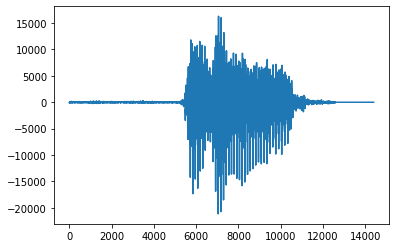

Number of channels 1
Sample width 2
Frame rate. 16000
Number of frames 12144
parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=12144, comptype='NONE', compname='not compressed')
/content/Simple-Audio-Recognition/Words_from_streams/no_bed_bird/3_no_bed_bird.wav
16000
[  0   0   0 ... -19   2   0]
sound durantion =  0.759


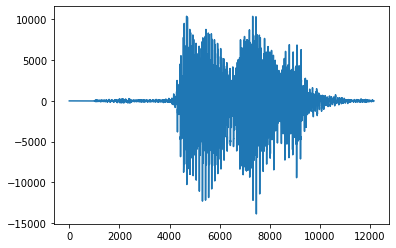

In [0]:

#+++++++++++++++++++22222222222222222222222222
start = k1
end = k2
x = '2_'

from pydub import silence, AudioSegment
audio = AudioSegment.from_file(dir_path + sample_file, format="wav")
print(audio)
segment = AudioSegment.from_wav(dir_path + sample_file)[start:end]  
modified_file = x +  sample_file  
segment.export(os.path.join(dir_path_mod, modified_file), format='wav')

import wave
sound = dir_path_mod + '/' + modified_file

obj = wave.open(sound,'r')
print( "Number of channels",obj.getnchannels())
print ( "Sample width",obj.getsampwidth())
print ( "Frame rate.",obj.getframerate())
print ("Number of frames",obj.getnframes())
print ( "parameters:",obj.getparams())
obj.close()
rate, data = scipy.io.wavfile.read(sound)
d = obj.getnframes()/obj.getframerate()
print(sound)
print(rate)
print(data)
print("sound durantion = ", d)
plt.plot(data)
plt.show()

#+++++++++++++++++++3333333333333333333333333333
k3 = 3000
start = k2
end = k3
x = '3_'

from pydub import silence, AudioSegment
audio = AudioSegment.from_file(dir_path + sample_file, format="wav")
print(audio)
segment = AudioSegment.from_wav(dir_path + sample_file)[start:end]  
modified_file = x +  sample_file  
segment.export(os.path.join(dir_path_mod, modified_file), format='wav')

import wave
sound = dir_path_mod + '/' + modified_file

obj = wave.open(sound,'r')
print( "Number of channels",obj.getnchannels())
print ( "Sample width",obj.getsampwidth())
print ( "Frame rate.",obj.getframerate())
print ("Number of frames",obj.getnframes())
print ( "parameters:",obj.getparams())
obj.close()
rate, data = scipy.io.wavfile.read(sound)
d = obj.getnframes()/obj.getframerate()
print(sound)
print(rate)
print(data)
print("sound durantion = ", d)
plt.plot(data)
plt.show()


В результате:
1. Создали директорий по названию фразы (/content/Simple-Audio-Recognition/Words_from_streams/no_bed_bird/)
2. Разделили первоначальную фразу (неотформатированную) на части. Части поместили в директорий (/content/Simple-Audio-Recognition/Words_from_streams/no_bed_bird/1_no_bed_bird.wav + 2_no_bed_bird.wav +3_no_bed_bird.wav).
3. Эти полученные слова - сырые. у них нестандартная длина и dataframe может быть не равным 16000. Поэтому перед тем, как скармливать их модели, слова нужно заново обработать. 
4. Обрабатываем слова вырезанные из фразы ноутбуком Директорий of Audio_Preparation.ipynb.  Он обрабатывает все файлы в директории. Сохраняем обработанные файлы в этом же директории.  



---



---





---



---

